# The Red Line Problem

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [7]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [8]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [9]:
from utils import set_pyplot_params
set_pyplot_params()

In Massachusetts, the Red Line is a subway that connects Cambridge and Boston. When I was working in Cambridge I took the Red Line from Kendall Square to South Station and caught the commuter rail to Needham. During rush hour Red Line trains run every 7–8 minutes, on average.

When I arrived at the station, I could estimate the time until the next train based on the number of passengers on the platform. If there were only a few people, I inferred that I just missed a train and expected to wait about 7 minutes. If there were more passengers, I expected the train to arrive sooner. But if there were a large number of passengers, I suspected that trains were not running on schedule, so I would go back to the street level and get a taxi.

While I was waiting for trains, I thought about how Bayesian estimation could help predict my wait time and decide when I should give up and take a taxi. This chapter presents the analysis I came up with.

This example is based on a project by Brendan Ritter and Kai Austin, who took a class with me at Olin College.
It was a chapter in the first edition of *Think Bayes*, but it got cut from the second edition.

Before we get to the analysis, we have to make some modeling decisions. First, I will treat passenger arrivals as a Poisson process, which means I assume that passengers are equally likely to arrive at any time, and that they arrive at an unknown rate, λ, measured in passengers per minute. Since I observe passengers during a short period of time, and at the same time every day, I assume that λ is constant.

On the other hand, the arrival process for trains is not Poisson. Trains to Boston are supposed to leave from the end of the line (Alewife station) every 7–8 minutes during peak times, but by the time they get to Kendall Square, the time between trains varies between 3 and 12 minutes.

To gather data on the time between trains, I wrote a script that downloads real-time data from http://www.mbta.com/rider_tools/developers/, selects south-bound trains arriving at Kendall square, and records their arrival times in a database. I ran the script from 4pm to 6pm every weekday for 5 days, and recorded about 15 arrivals per day. Then I computed the time between consecutive arrivals; the distribution of these gaps is shown in Figure 8.1, labeled z.

In [13]:
OBSERVED_GAP_TIMES = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]

In [14]:
import numpy as np

zs = np.array(OBSERVED_GAP_TIMES) / 60

In [15]:
from utils import kde_from_sample

qs = np.linspace(0, 20, 101)
pmf_z = kde_from_sample(zs, qs)

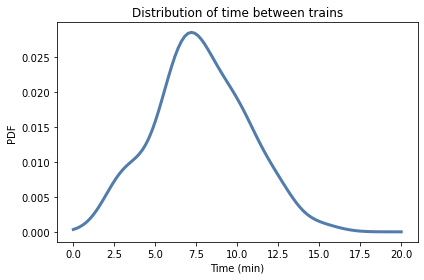

In [17]:
from utils import decorate

pmf_z.plot()

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time between trains')

If you stood on the platform from 4pm to 6pm and recorded the time between trains, this is the distribution you would see. But if you arrive at some random time (without regard to the train schedule) you would see a different distribution. The average time between trains, as seen by a random passenger, is substantially higher than the true average.

Why? Because a passenger is more like to arrive during a large interval than a small one. Consider a simple example: suppose that the time between trains is either 5 minutes or 10 minutes with equal probability. In that case the average time between trains is 7.5 minutes.

But a passenger is more likely to arrive during a 10 minute gap than a 5 minute gap; in fact, twice as likely. If we surveyed arriving passengers, we would find that 2/3 of them arrived during a 10 minute gap, and only 1/3 during a 5 minute gap. So the average time between trains, as seen by an arriving passenger, is 8.33 minutes.

[This kind of sampling bias appears in many contexts](https://towardsdatascience.com/the-inspection-paradox-is-everywhere-2ef1c2e9d709). Students think that classes are bigger than they are because more of them are in the big classes. Airline passengers think that planes are fuller than they are because more of them are on full flights.

In each case, values from the actual distribution are oversampled in proportion to their value. In the Red Line example, a gap that is twice as big is twice as likely to be observed.

We can compute the distribution of gaps seen by passengers by multiplying the probabilities in `pmf_z` by the quantities themselves, and renormalizing.

In [18]:
pmf_zb = pmf_z * pmf_z.qs
pmf_zb.normalize()

7.772927524715933

The following figureshows the actual distribution of gaps, labeled z, and the distribution of gaps seen by passengers, labeled zb for “z biased”.

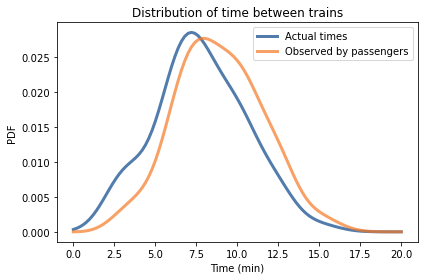

In [20]:
pmf_z.plot(label='Actual times')
pmf_zb.plot(label='Observed by passengers')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time between trains')

Wait time, which I call y, is the time between the arrival of a passenger and the next arrival of a train. Elapsed time, which I call x, is the time between the arrival of the previous train and the arrival of a passenger. I chose these definitions so that 

```
zb = x + y.
```

Given the distribution of zb, we can compute the distribution of y. I’ll start with a simple case and then generalize. Suppose, as in the previous example, that zb is either 5 minutes with probability 1/3, or 10 minutes with probability 2/3.

If we arrive at a random time during a 5 minute gap, y is uniform from 0 to 5 minutes. If we arrive during a 10 minute gap, y is uniform from 0 to 10. So the overall distribution is a mixture of uniform distributions weighted according to the probability of each gap.

Given the distribution of `zb`, here's how we compute the distribution of `y`.

In [95]:
from empiricaldist import Pmf

def make_dist_wait(gap, qs):
    qs = qs[qs <= gap]
    n = len(qs)
    return Pmf(1/n, qs)

qs = pmf_zb.qs
pmf_seq = [make_dist_wait(gap, qs) for gap in qs]
pmf_seq[0]

,probs
0.0,1.0


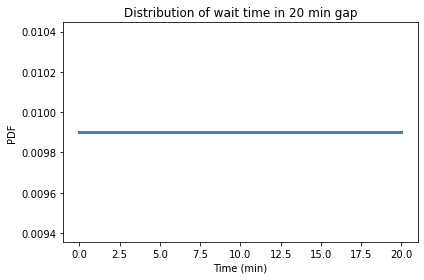

In [96]:
pmf_seq[-1].plot()

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of wait time in 20 min gap')

In [97]:
from utils import make_mixture

pmf_y = make_mixture(pmf_zb, pmf_seq)

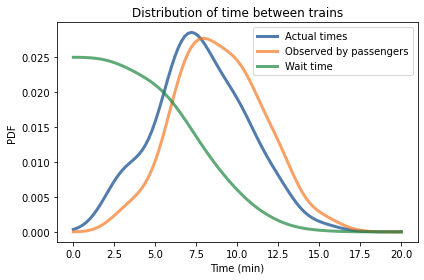

In [39]:
pmf_z.plot(label='Actual times')
pmf_zb.plot(label='Observed by passengers')
pmf_y.plot(label='Wait time')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time between trains')

In [41]:
pmf_z.mean(), pmf_zb.mean(), pmf_y.mean()

(7.772927524715933, 8.89677416786441, 4.448387083932206)

The mean of z is 7.8 minutes. The mean of zb is 8.9 minutes, about 13% higher. The mean of y is 4.45, half the mean of zb.

As an aside, the Red Line schedule reports that trains run every 9 minutes during peak times. This is close to the average of zb, but higher than the average of z. I exchanged email with a representative of the MBTA, who confirmed that the reported time between trains is deliberately conservative in order to account for variability.

## Predicting wait times

Let’s get back to the motivating question: suppose that when I arrive at the platform I see 10 people waiting. How long should I expect to wait until the next train arrives?

As always, let’s start with the easiest version of the problem and work our way up. Suppose we are given the actual distribution of z, and we know that the passenger arrival rate, λ, is 2 passengers per minute.

Remember that we've defined `x` to be the elapsed time since the last train and `y` to be the wait time until the next train.  In the previous section, we derived the distribution of `y`.  Well, the distribution of `x` is actually the same.

So when we arrive at the station, the prior distribution of `x` is the same as `pmf_y`.





In [43]:
prior_x = pmf_y

Given the parameters of the problem, we can compute the likelihood of finding 10 passengers on the platform, for each possible value of `x`:

In [51]:
from scipy.stats import poisson

lam = 2
num_passengers = 10
likelihood = poisson(lam * prior_x.qs).pmf(num_passengers)

And we can do the update in the usual way.

In [52]:
posterior_x = prior_x * likelihood
posterior_x.normalize()

0.04757676716097805

Here's what the posterior of `x` looks like.

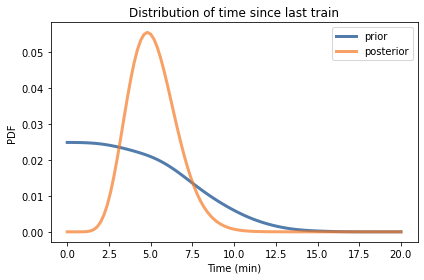

In [53]:
prior_x.plot(label='prior')
posterior_x.plot(label='posterior')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time since last train')

Based on the number of passengers, we think it has been about 5 minutes since the last train.

In [54]:
prior_x.mean(), posterior_x.mean()

(4.448387083932206, 5.1439350761797495)

Now how long do we think it will be until the next train?
Based on what we know so far, the distribution of `z` is `pmf_zb`, and the distribution of `x` is `posterior_x`, so the distribution of `y` is

In [64]:
posterior_y = Pmf.sub_dist(pmf_zb, posterior_x)

In [65]:
nonneg = (posterior_y.qs >= 0)
posterior_y = Pmf(posterior_y[nonneg])
posterior_y.normalize()

0.8900343090047254

Based on the information so far, here are the distributions for `x`, `y`, and `z`.

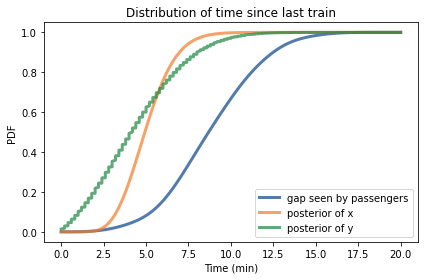

In [67]:
pmf_zb.make_cdf().plot(label='gap seen by passengers')
posterior_x.make_cdf().plot(label='posterior of x')
posterior_y.make_cdf().plot(label='posterior of y')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time since last train')

At this point we can use the number of passengers on the platform to predict the distribution of wait times. Now let’s get to the second part of the question: when should I stop waiting for the train and go catch a taxi?

Remember that in the original scenario, I am trying to get to South Station to catch the commuter rail. Suppose I leave the office with enough time that I can wait 15 minutes and still make my connection at South Station.

In that case I would like to know the probability that `y` exceeds 15 minutes as a function of `num_passengers`. It is easy enough to use the analysis from the previous section and run it for a range of `num_passengers`.

But there’s a problem. The analysis is sensitive to the frequency of long delays, and because long delays are rare, it is hard to estimate their frequency.

I only have data from one week, and the longest delay I observed was 15 minutes. So I can’t estimate the frequency of longer delays accurately.

However, I can use previous observations to make at least a coarse estimate. When I commuted by Red Line for a year, I saw three long delays caused by a signaling problem, a power outage, and “police activity” at another stop. So I estimate that there are about 3 major delays per year.

But remember that my observations are biased. I am more likely to observe long delays because they affect a large number of passengers. So we should treat my observations as a sample of `zb` rather than `z`. Here’s how we can do that.

In [82]:
sample = pmf_zb.sample(365)
delays = [30, 40, 50]
sample_zb = np.append(sample, delays)

In [87]:
qs = np.linspace(0, 60, 101)
pmf_zb2 = kde_from_sample(sample_zb, qs)

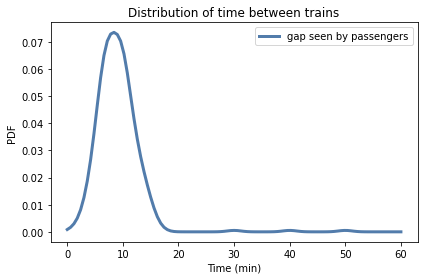

In [94]:
pmf_zb2.plot(label='gap seen by passengers')

decorate(xlabel='Time (min)',
         ylabel='PDF',
         title='Distribution of time between trains')

In [93]:
pmf_zb2.sum()

0.9999999999999998

Now let's take the previous analysis and wrap it in a function.

In [118]:
qs = pmf_zb2.qs
pmf_seq = [make_dist_wait(gap, qs) for gap in qs]
pmf_y = make_mixture(pmf_zb2, pmf_seq)
prior_x = pmf_y
lam = 2
num_passengers = 10

def compute_posterior_y(num_passengers):    
    likelihood = poisson(lam * qs).pmf(num_passengers)
    posterior_x = prior_x * likelihood
    posterior_x.normalize()
    posterior_y = Pmf.sub_dist(pmf_zb2, posterior_x)
    nonneg = (posterior_y.qs >= 0)
    posterior_y = Pmf(posterior_y[nonneg])
    posterior_y.normalize()
    return posterior_y

Given the number of passengers when we arrive at the station, it computes the posterior distribution of `y`.

In [ ]:
posterior_y = compute_posterior_y(10)

Which we can use to compute the mean wait time and the probability of waiting more than 15 minutes.

In [146]:
posterior_y.mean()

4.721168650652226

In [147]:
1 - posterior_y.make_cdf()(15)

0.009413462298188402

If we see 10 passengers, we expect to wait a little less than 5 minutes, and the chance of waiting more than 15 minutes is about 1%.

Let's see what happens if we sweep through a range of values for `num_passengers`.

In [148]:
nums = np.arange(0, 37, 3)
posteriors = [compute_pmf_y(num) for num in nums]

In [149]:
mean_wait = [posterior_y.mean()
             for posterior_y in posteriors]

Here's the mean wait as a function of the number of passengers.

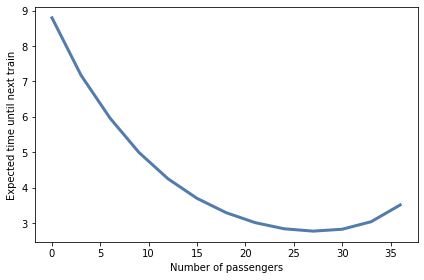

In [142]:
import matplotlib.pyplot as plt

plt.plot(nums, mean_wait)

decorate(xlabel='Number of passengers',
         ylabel='Expected time until next train')

In [137]:
prob_late = [1 - posterior_y.make_cdf()(15) 
             for posterior_y in posteriors]

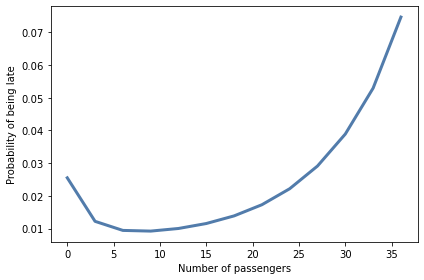

In [143]:
import matplotlib.pyplot as plt

plt.plot(nums, prob_late)

decorate(xlabel='Number of passengers',
         ylabel='Probability of being late')

When the number of passengers is less than 20, we infer that the system is operating normally, so the probability of a long delay is small. If there are 30 passengers, we suspect that something is wrong and expect longer delays.

If we are willing to accept a 5% chance of missing the connection at South Station, we should stay and wait as long as there are fewer than 30 passengers, and take a taxi if there are more.

Or, to take this analysis one step further, we could quantify the cost of missing the connection and the cost of taking a taxi, then choose the threshold that minimizes expected cost.

This analysis is based on the assumption that the arrival rate, `lam`, is known.
If it is not know precisely, but is estimated from data, we could represent our uncertainty about `lam` with a distribution, compute the distribution of `y` for each value of `lam`, and make a mixture to represent the distribution of `y`.
I did that in the version of this problem in the first edition of *Think Bayes*; I left it out here because it is not the focus of the problem.
